# MPO 762 - Problem Set 3

### Tiago Carrilho Bilo 
### C$\#$11950866


## 1 Quest for a stable time integration scheme 

# .

Lets discretize the advection equation

$$u_{t} + c u_{x} = 0$$

using the following fifth-order backward discretization in space

$$\frac{d u_{j}}{d t} = \frac{-c}{60 \Delta x} \times [-2 u_{j-3} + 15 u_{j-2} - 60 u_{j-1} + 20 u_{j} + 30 u_{j+1} - 3 u_{j+2}]$$

where $\Delta x$ is the grid spacing and $_{j}$ the grid indexing. Decomposing the fuction $u(x,t)$ in a Discrete Fourier series (i. e., $u = \sum \hat{u}_{m}(t) e^{i k_{m} x_{j}}$) we get an ODE for each wave in the series of the form

$$\frac{d \hat{u}}{d t} = \frac{-c}{60 \Delta x} \times [-2 e^{-3ik\Delta x} + 15 e^{-2ik\Delta x} -60 e^{-ik\Delta x} + 20 + 30 e^{ik\Delta x} - 3 e^{2ik\Delta x}]\times \hat{u}$$

where $k$ is the wave number. Assuming the specific form $\frac{d \hat{u}}{d t} = \kappa \hat{u}$ we find that $\kappa$ is a complex number

$$\kappa = [-2 e^{-3ik\Delta x} + 15 e^{-2ik\Delta x} -60 e^{-ik\Delta x} + 20 + 30 e^{ik\Delta x} - 3 e^{2ik\Delta x}]$$

$$Re(\kappa) = \frac{-c}{30\Delta x} \times [-cos(3k\Delta x) + 6cos(2k\Delta x) + 10 - 15cos(k\Delta x)]$$

$$Im(\kappa) = \frac{-c}{30\Delta x} \times [sin(3k\Delta x) - 9sin(2k\Delta x) + 45sin(k\Delta x)]$$

# .

Therefore in order to find the stability properties of this discretization method in space, we can look at the number $\frac{\kappa \Delta t}{\mu} = \frac{\kappa \Delta x}{c}$ as a function of $k \Delta x$, where $\mu$ is known as Courant number. 

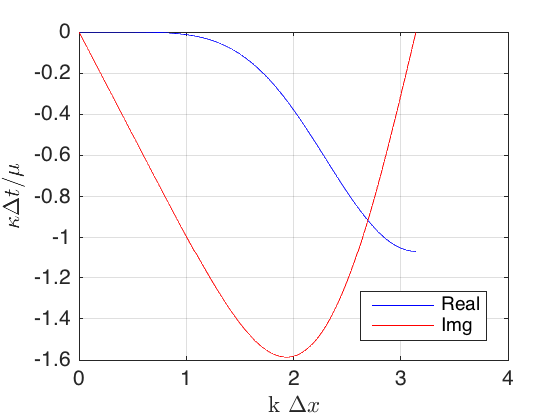

[outputs]
Real part: Max = 0  Min = -1.0667
Imaginary part: Max = 0  Min = -1.586


In [1]:
% Clear memory and close all figures
clear all 
close all 

% Since kappa is a combination of sines and cosines lets make kdx vary between 0 and kmaxdx = pi
% kmax has to be 2*pi/2dx (i. e., Nyquist wavenumber = 2dx) 

% studying all possible combinations os kdx
kdx = linspace(0,pi,500);


% kappa.dt/mu 
real_kappadt = (-cos(3*kdx) + 6*cos(2*kdx) - 15*cos(kdx) + 10)/(-30);
img_kappadt = (sin(3*kdx) - 9*sin(2*kdx) + 45*sin(kdx))/(-30);

% Maxima and minima of kappa.dt/mu
disp('[outputs]')
disp(['Real part: Max = ',num2str(max(real_kappadt)),'  Min = ',num2str(min(real_kappadt))])
disp(['Imaginary part: Max = ',num2str(max(img_kappadt)),'  Min = ',num2str(min(img_kappadt))])

% Plots
plot(kdx,real_kappadt,'b',kdx,img_kappadt,'r')
grid 'on'
legend('Real','Img','Location','SouthEast')
xlabel('k $\Delta x$','Interpret','latex');
ylabel('$\kappa \Delta t/\mu$','Interpret','latex');


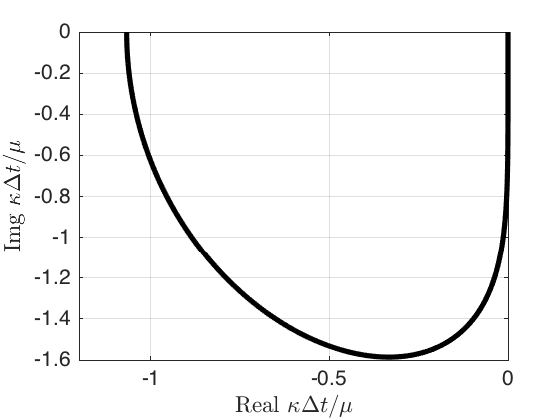

In [2]:
plot(real_kappadt,img_kappadt,'k','linewidth',2.5)
grid 'on'
xlabel('Real $\kappa \Delta t/\mu$','Interpret','latex');
ylabel('Img $\kappa \Delta t/\mu$','Interpret','latex');

From the ODE $\frac{d \hat{u}}{d t} = \kappa \hat{u}$ we can verify that 

$$\hat{u}(t) = \hat{u}(t = 0) e^{\kappa t}$$

Assming the amplification factor $A$ would be constant at every time steps we get

$$A = \frac{u^{n+1}}{u^{n}} = e^{\kappa \Delta t}$$

therefore for stability $Re(\kappa \Delta t) \le 0$. 


# .

Based on the stability of time-stepping schemes discussed in class, we could use the Runge-Kutta method of order 4 (RK4). In terms of stability constranits, it is necessary that the maximum absolute value of the stable imaginary part (i. e., $|Im(\frac{\kappa \Delta t}{\mu})|$) of the RK4 scheme be less or equal to 1.586. Therefore $\mu$ must be between 0 and $\sim$1.75. 

The numerical dissipation will occur on waves (i. e., $k \Delta x$) that have the corresponding $Re(\frac{\kappa \Delta t}{\mu} < 0)$ (see figures above).

In [3]:
% Waves under numerical dissipation
ndi = find(real_kappadt ~= 0);
max_ndi = find(real_kappadt == min(real_kappadt));

disp('[outputs]')
disp(['dissipation will occur for kdx between ',num2str(kdx(ndi(1))),'<kdx<',num2str(kdx(ndi(end)))])

disp(['maximum dissipation will occur for kdx=',num2str(kdx(max_ndi))])

[outputs]
dissipation will occur for kdx between 0.0062958<kdx<3.1416
maximum dissipation will occur for kdx=3.1416


# .

Finally, if c becomes negative the RK4 time-integration scheme would still be stable due to the RK4 stability region. 

## 2 Programming FDA to advection equation 

The following code integrate in time the advection equation using the 5th order FDA in space mentioned above and the Runge Kutta 3rd order for time stepping. 

As initial conditions we will consider two different functions: 

- Smooth initial condition: $u(x,0) = tanh\{\alpha [cos(\pi x) + \frac{1}{2}]\} + e^{-cos^{2}(\pi x)}$
- Inverted parabola: $u(x,0) = max(0 , 1 - 4 x^{2})$

In [4]:
% Clear memory and close all figures
clear all 
close all 

% Define the domain
xmin = -1.0; 
xmax = 1.0; 

% Define the BC of the problem (flag periodic = 1, use periodic boundary condition)
periodic=1;        

% define initial condition functions
init1 = inline('tanh(4.0*(cos(pi*xe) + 0.5)) + exp(-cos(pi*xe).^2)');      % Smooth initial condition 
init2 = inline('max(0,1-4.0*(xe.^2))');                                  % Inverted parabola 

### Experiment with 64 grid cells

In [5]:
% Define the computational grid
N=64;                            % number of grid cells 
[x,xe,dx] = FDGrid(xmin,xmax,N);

% Define integration time and number of time steps
courant  = 0.5;                  % courant number
c  = 1.0;                        % advective velocity
dt = courant*dx/c;               % time step
n_steps = 10*(xmax-xmin)/c/dt;   % number of time steps for 10 circuits complete (number of integrations) 

% Initial Conditions
u1_t0 = init1(xe);
u2_t0 = init2(xe);


%% Integration in time 
isnap = n_steps/10;              % Define how often (# of time steps) to plot and save the solution
is = 1;

% For unitial condition u1_t0
u1 = ones(10,length(xe))*nan;    % Solutions

% For unitial condition u12_t0
u2 = ones(10,length(xe))*nan;    % Solutions 

time = ones(10)*nan;

p1 = u1_t0;
p2 = u2_t0;

for it = 1:n_steps

  % RK3 time step 
  p1 = rk3(p1,c,dx,dt,periodic);
  p2 = rk3(p2,c,dx,dt,periodic);

  % Saving solutions 
  if (mod(it,isnap)==0)
    u1(is,:) = p1;
    u2(is,:) = p2;
    time(is) = it*dt;
    is = is+1;
  end
end

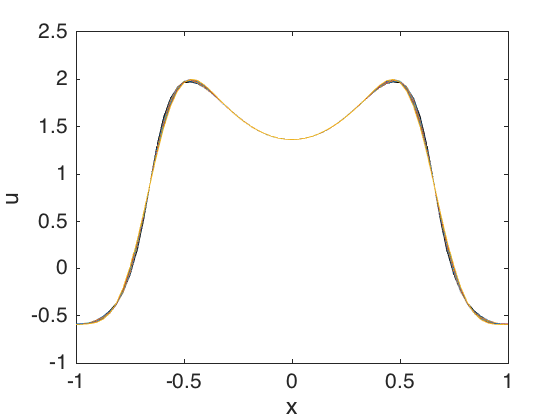

In [6]:
% Plot solutions - Smooth Initial Condition 
plot(xe,u1_t0,'k');
hold 'on'
    
for i =[1:10]
    plot(xe,u1(i,:));

end
    
xlabel('x'); 
ylabel('u');

Figure 2. Solutions of the function u at the end of each cycle using the smooth initial condition and 64 cells. Note that the numerical scheme is consistent and stable. 

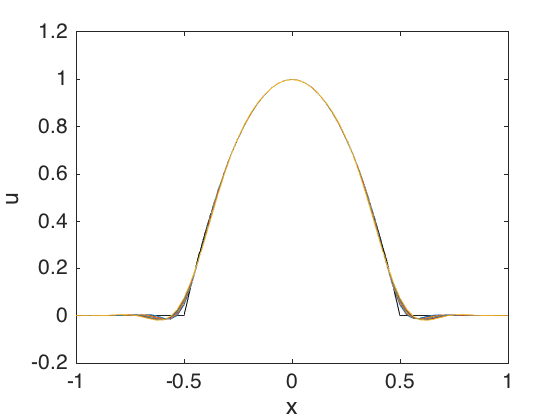

In [7]:
% Plot solutions - Inverted Parabola Initial Condition 
plot(xe,u2_t0,'k');
hold 'on'
    
for i =[1:10]
    plot(xe,u2(i,:));
end
    
xlabel('x'); 
ylabel('u');

Figure 3. Solutions of the function u at the end of each cycle using the inverted parabola initial condition and 64 cells. Note that the numerical scheme is consistent and stable.

In [8]:
% Error Measurement between the final time steps and the initial conditions
err1 = (u1_t0-u1(end,:));
emax1=max(abs(err1));
erms1=sqrt(sum(err1.^2))*dx;

err2 = (u2_t0-u2(end,:));
emax2=max(abs(err2));
erms2=sqrt(sum(err2.^2))*dx;

disp('[outputs]')
disp(strcat('Errors         : N      Emax       RMS'));
disp(strcat('Errors smooth  : ',num2str([N emax1 erms1])));
disp(strcat('Errors parabola: ',num2str([N emax2 erms2])));

[outputs]
Errors         : N      Emax       RMS
Errors smooth  :64     0.110937    0.0107279
Errors parabola:64    0.0743076   0.00420818


Note that the errors involved with the inverted parabola initial condition are smaller than the ones obtained for the smooth initial conditions. Although in the first case the numerical problems are evident close to grid points where the derivative of the function is not defined (i. e. edges of the parabola, see Figure 3), the second seems to suffer of numerical diffusion.

### Experiment with 128 grid cells

In [9]:
% Define the computational grid
N=128;                           % number of grid cells 
[x,xe,dx] = FDGrid(xmin,xmax,N);

% Define integration time and number of time steps
courant  = 0.5;                  % courant number
c  = 1.0;                        % advective velocity
dt = courant*dx/c;               % time step
n_steps = 10*(xmax-xmin)/c/dt;   % number of time steps for 10 circuits complete (number of integrations) 

% Initial Conditions
u1_t0 = init1(xe);
u2_t0 = init2(xe);


%% Integration in time 
isnap = n_steps/10;              % Define how often (# of time steps) to plot and save the solution
is = 1;

% For unitial condition u1_t0
u1 = ones(10,length(xe))*nan;    % Solutions

% For unitial condition u12_t0
u2 = ones(10,length(xe))*nan;    % Solutions 

time = ones(10)*nan;

p1 = u1_t0;
p2 = u2_t0;

for it = 1:n_steps

  % RK3 time step 
  p1 = rk3(p1,c,dx,dt,periodic);
  p2 = rk3(p2,c,dx,dt,periodic);

  % Saving solutions 
  if (mod(it,isnap)==0)
    u1(is,:) = p1;
    u2(is,:) = p2;
    time(is) = it*dt;
    is = is+1;
  end
end

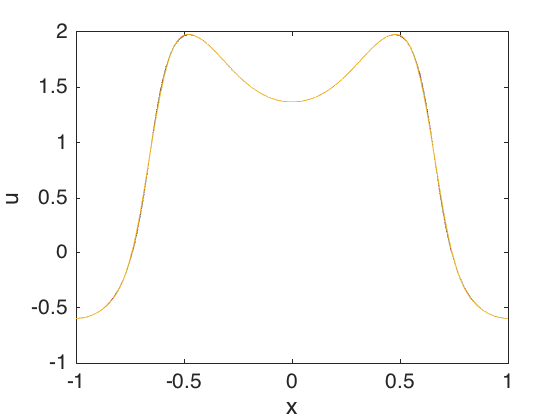

In [10]:
% Plot solutions - Smooth Initial Condition 
plot(xe,u1_t0,'k');
hold 'on'
    
for i =[1:10]
    plot(xe,u1(i,:));

end
    
xlabel('x'); 
ylabel('u');

Figure 4. Solutions of the function u at the end of each cycle using the smooth initial condition and 128 cells.

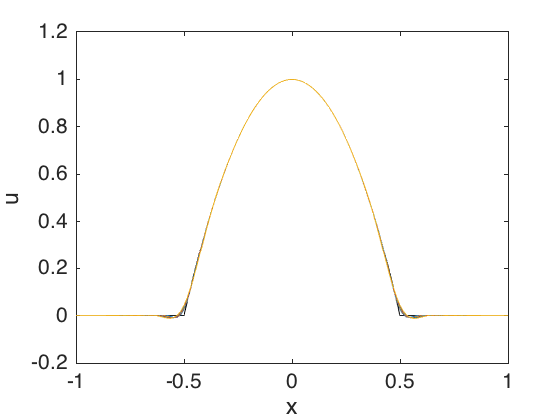

In [11]:
% Plot solutions - Inverted Parabola Initial Condition 
plot(xe,u2_t0,'k');
hold 'on'
    
for i =[1:10]
    plot(xe,u2(i,:));
end
    
xlabel('x'); 
ylabel('u');

Figure 5. Solutions of the function u at the end of each cycle using the inverted parabola initial condition and 128 cells.

In [12]:
% Error Measurement between the final time steps and the initial conditions
err1 = (u1_t0-u1(end,:));
emax1=max(abs(err1));
erms1=sqrt(sum(err1.^2))*dx;

err2 = (u2_t0-u2(end,:));
emax2=max(abs(err2));
erms2=sqrt(sum(err2.^2))*dx;

disp('[outputs]')
disp(strcat('Errors         : N      Emax       RMS'));
disp(strcat('Errors smooth  : ',num2str([N emax1 erms1])));
disp(strcat('Errors parabola: ',num2str([N emax2 erms2])));

[outputs]
Errors         : N      Emax       RMS
Errors smooth  :128    0.02695671   0.001529822
Errors parabola:128    0.04329442   0.001279557


The improvment in the numerical scheme using a smooth initial condition is evident when the grid spacing is reduced. From Figure 4 whe can see that the "dispersion" of the solution at each grid cell is smaller indicating a problem with the coarser model resolution. On the other hand, the improvement in the numerical scheme using the inverted parabola initial condition was not as drastic. The largest errors are still located at the discontinuity points with similar magnitue as the coarse resolution solutions. 

Therefore, we can conclude that high-order methods are very effective on reducing errors for smooth solutions, but not as good on discontinous functions.